In [ ]:
import os
import shutil
from google.colab import drive

# Ensure the mount point is empty before mounting
mountpoint = '/content/drive'

# Check if the mountpoint exists and is not empty
if os.path.exists(mountpoint) and os.path.isdir(mountpoint) and os.listdir(mountpoint):
    print(f"Mountpoint '{mountpoint}' is not empty. Attempting to clear...")
    try:
        # Use shell command for recursive removal, typically faster and more robust
        !rm -rf {mountpoint}/*
        print(f"Cleared contents of '{mountpoint}'.")
        # Recreate the directory if it was removed by rm -rf *
        os.makedirs(mountpoint, exist_ok=True)
    except Exception as e:
        print(f"Error clearing mountpoint '{mountpoint}': {e}")
        # If clearing fails, you might need manual intervention or skip mounting
        # For this case, we'll proceed with mounting, but be aware it might still fail
        pass # Or handle the error appropriately

# Now mount Google Drive
drive.mount(mountpoint , force_remount=True)

In [ ]:
# === The New, Fast, and Space-Efficient Data Setup Script ===
# This version copies zips to a temp area and deletes each zip
# immediately after unzipping to manage disk space.

import os
import glob
import time
import shutil
from google.colab import drive

# --- Configuration ---
DRIVE_ZIPPED_DATA_DIR = "/content/drive/MyDrive/zipped"
LOCAL_DATASET_DIR = "/content/local_data"
# A dedicated temporary directory for the zip files
LOCAL_TEMP_ZIP_DIR = "/content/temp_zips"
# --- End of Configuration ---


# --- Main Logic ---
print("--- Starting Fast & Space-Efficient Data Setup ---")
start_time_total = time.time()
drive.mount('/content/drive', force_remount=True)

# Define the final local paths for each data type
local_real_dir = os.path.join(LOCAL_DATASET_DIR, "real_frames")
local_fake_dir = os.path.join(LOCAL_DATASET_DIR, "fake_frames")
local_flow_dir = os.path.join(LOCAL_DATASET_DIR, "precomputed_flow_features")

# Create the main local data directory and subdirectories
os.makedirs(local_real_dir, exist_ok=True)
os.makedirs(local_fake_dir, exist_ok=True)
os.makedirs(local_flow_dir, exist_ok=True)
# NEW: Create the dedicated temporary directory for zip files
os.makedirs(LOCAL_TEMP_ZIP_DIR, exist_ok=True)
print(f"Local data directories created at '{LOCAL_DATASET_DIR}'")


# --- Step 1: Copy all zipped chunks into the temporary local directory ---
print(f"\n--- Step 1: Copying all zip chunks from Drive to '{LOCAL_TEMP_ZIP_DIR}'... ---")
start_time_copy = time.time()

source_zip_pattern = os.path.join(DRIVE_ZIPPED_DATA_DIR, "*.zip")
zip_files_to_copy = glob.glob(source_zip_pattern)

if not zip_files_to_copy:
    print(f"❌ ERROR: No .zip files found using glob at '{source_zip_pattern}'. Please re-check the path.")
else:
    print(f"Found {len(zip_files_to_copy)} zip files to copy.")
    for source_path in zip_files_to_copy:
        # The destination is now the dedicated temp directory
        shutil.copy(source_path, LOCAL_TEMP_ZIP_DIR)

    end_time_copy = time.time()
    print(f"-> Copying all zips finished in {end_time_copy - start_time_copy:.2f} seconds.")


# --- Step 2: Unzip, Combine, and Incrementally Delete the Chunks ---
print("\n--- Step 2: Unzipping chunks and deleting zips to save space... ---")

# A) Process 'real_frames' chunks
# The glob pattern now looks inside the temp directory
real_zips = sorted(glob.glob(os.path.join(LOCAL_TEMP_ZIP_DIR, "real_frames_chunk_*.zip")))
if real_zips:
    print(f"  Unzipping {len(real_zips)} 'real_frames' chunks into '{local_real_dir}'...")
    for zip_file in real_zips:
        # Unzip the file
        !unzip -q -o "{zip_file}" -d "{local_real_dir}"
        # Immediately delete the zip file to free up space
        os.remove(zip_file)
        print(f"    - Unzipped and deleted {os.path.basename(zip_file)}")
else:
    print("  Warning: No 'real_frames' zip chunks found in temp directory.")

# B) Process 'fake_frames' chunks
fake_zips = sorted(glob.glob(os.path.join(LOCAL_TEMP_ZIP_DIR, "fake_frames_chunk_*.zip")))
if fake_zips:
    print(f"  Unzipping {len(fake_zips)} 'fake_frames' chunks into '{local_fake_dir}'...")
    for zip_file in fake_zips:
        !unzip -q -o "{zip_file}" -d "{local_fake_dir}"
        os.remove(zip_file)
        print(f"    - Unzipped and deleted {os.path.basename(zip_file)}")
else:
    print("  Warning: No 'fake_frames' zip chunks found in temp directory.")

# C) Process 'precomputed_flow' chunk
flow_zips = sorted(glob.glob(os.path.join(LOCAL_TEMP_ZIP_DIR, "Combined_Precomputed_Flow*.zip")))
if flow_zips:
    print(f"  Unzipping {len(flow_zips)} 'precomputed_flow' chunk(s) into '{local_flow_dir}'...")
    for zip_file in flow_zips:
        !unzip -q -o "{zip_file}" -d "{local_flow_dir}"
        os.remove(zip_file)
        print(f"    - Unzipped and deleted {os.path.basename(zip_file)}")
else:
    print("  Warning: No 'precomputed_flow' zips found in temp directory.")


# --- Step 3: Final Verification and Cleanup ---
print("\n--- Step 3: Verifying and cleaning up... ---")
try:
    num_real = len(os.listdir(local_real_dir))
    num_fake = len(os.listdir(local_fake_dir))
    num_flow = len(os.listdir(local_flow_dir))

    print(f"  Verification successful:")
    print(f"  - Real frames folder: {num_real} files")
    print(f"  - Fake frames folder: {num_fake} files")
    print(f"  - Flow features folder: {num_flow} files")
except FileNotFoundError as e:
    print(f"  Verification failed. A directory was not created correctly: {e}")

# Clean up the (now empty) temporary directory for the zips
print(f"  Cleaning up temporary directory: '{LOCAL_TEMP_ZIP_DIR}'...")
shutil.rmtree(LOCAL_TEMP_ZIP_DIR)

end_time_total = time.time()
print(f"\n✅ SUCCESS! Your dataset is ready for training in {end_time_total - start_time_total:.2f} seconds.")

--- Starting Fast & Space-Efficient Data Setup ---
Mounted at /content/drive
Local data directories created at '/content/local_data'

--- Step 1: Copying all zip chunks from Drive to '/content/temp_zips'... ---
Found 39 zip files to copy.
-> Copying all zips finished in 631.93 seconds.

--- Step 2: Unzipping chunks and deleting zips to save space... ---
  Unzipping 19 'real_frames' chunks into '/content/local_data/real_frames'...
    - Unzipped and deleted real_frames_chunk_01_000000-009999.zip
    - Unzipped and deleted real_frames_chunk_02_010000-019999.zip
    - Unzipped and deleted real_frames_chunk_03_020000-029999.zip
    - Unzipped and deleted real_frames_chunk_04_030000-039999.zip
    - Unzipped and deleted real_frames_chunk_05_040000-049999.zip
    - Unzipped and deleted real_frames_chunk_06_050000-059999.zip
    - Unzipped and deleted real_frames_chunk_07_060000-069999.zip
    - Unzipped and deleted real_frames_chunk_08_070000-079999.zip
    - Unzipped and deleted real_frames

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import glob
from collections import defaultdict
import random
import gc
import re
from PIL import Image
import time
import math

# --- Debug Flag ---
DEBUG_VERBOSE = False

# --- Global Configurations ---
SEQUENCE_LENGTH = 30
# CNN-ViT Specific Hyperparameters
VIT_EMBED_DIM = 768
VIT_NUM_HEADS = 12
VIT_NUM_LAYERS = 6 # Start with fewer layers for stability/speed
VIT_MLP_DIM = 3072 # Typically 4 * VIT_EMBED_DIM
FLOW_DIM = 2
NUM_CLASSES = 2

# --- PATHS ---
# Define local Colab destination paths (where the script will read from after copying)
# --- PATHS (ASSUMING DATA IS ALREADY COPIED LOCALLY) ---
LOCAL_REAL_FRAMES_DIR = '/content/local_data/real_frames'
LOCAL_FAKE_FRAMES_DIR = '/content/local_data/fake_frames'
PRECOMPUTED_FLOW_DIR_FOR_DATASET = '/content/local_data/precomputed_flow_features'


# Output Paths (on Google Drive)
DRIVE_OUTPUT_BASE = f'/content/drive/MyDrive/final_balanced_data/cnn__vit_SL{SEQUENCE_LENGTH}_output' # Added v2 for new run
LOG_FILE_PATH = os.path.join(DRIVE_OUTPUT_BASE, 'training_log_cnn_vit.txt')
BEST_MODEL_SAVE_PATH = os.path.join(DRIVE_OUTPUT_BASE, f'best_model_cnn_vit_L{VIT_NUM_LAYERS}.pth')
OUTPUT_DIR_FOR_PLOTS_AND_REPORTS = os.path.join(DRIVE_OUTPUT_BASE, 'reports_and_plots_cnn_vit')

# Fallback local paths for outputs if Drive fails
LOCAL_OUTPUT_BASE_FALLBACK = f'/content/outputs_local_cnn_vit_SL{SEQUENCE_LENGTH}_v2'
_LOG_FILE_PATH_TEMP = os.path.join(LOCAL_OUTPUT_BASE_FALLBACK, 'training_log_cnn_vit.txt')
_BEST_MODEL_SAVE_PATH_TEMP = os.path.join(LOCAL_OUTPUT_BASE_FALLBACK, f'best_model_cnn_vit_L{VIT_NUM_LAYERS}.pth')
_OUTPUT_DIR_FOR_PLOTS_AND_REPORTS_TEMP = os.path.join(LOCAL_OUTPUT_BASE_FALLBACK, 'reports_and_plots_cnn_vit')

# --- Mount Drive and Setup Output Dirs ---
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted.")
    # Use the actual DRIVE_OUTPUT_BASE for creating directories
    os.makedirs(os.path.dirname(LOG_FILE_PATH), exist_ok=True)
    os.makedirs(os.path.dirname(BEST_MODEL_SAVE_PATH), exist_ok=True)
    os.makedirs(OUTPUT_DIR_FOR_PLOTS_AND_REPORTS, exist_ok=True)
    print(f"Output directories on Drive ensured/created at {DRIVE_OUTPUT_BASE}")
except Exception as e:
    print(f"Warning: Drive mount/setup error: {e}. Using local fallback for outputs.")
    # Switch global output paths to local fallback versions
    DRIVE_OUTPUT_BASE = LOCAL_OUTPUT_BASE_FALLBACK # This redefines the base for subsequent path joinings
    LOG_FILE_PATH = _LOG_FILE_PATH_TEMP
    BEST_MODEL_SAVE_PATH = _BEST_MODEL_SAVE_PATH_TEMP
    OUTPUT_DIR_FOR_PLOTS_AND_REPORTS = _OUTPUT_DIR_FOR_PLOTS_AND_REPORTS_TEMP
    os.makedirs(os.path.dirname(LOG_FILE_PATH), exist_ok=True)
    os.makedirs(os.path.dirname(BEST_MODEL_SAVE_PATH), exist_ok=True)
    os.makedirs(OUTPUT_DIR_FOR_PLOTS_AND_REPORTS, exist_ok=True)
    print(f"Using LOCAL fallback paths for outputs: {DRIVE_OUTPUT_BASE}")


# --- PositionalEncoding Class ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50): # max_len should be >= sequence_length + 1 (for CLS)
        super(PositionalEncoding, self).__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]

# --- DeepfakeDetectionModel_CNNViT Class ---
class DeepfakeDetectionModel_CNNViT(nn.Module):
    def __init__(self,
                 cnn_output_dim_from_resnet=512,
                 vit_embed_dim=VIT_EMBED_DIM, # Use global
                 vit_num_heads=VIT_NUM_HEADS, # Use global
                 vit_num_layers=VIT_NUM_LAYERS, # Use global
                 vit_mlp_dim=VIT_MLP_DIM, # Use global
                 sequence_length=SEQUENCE_LENGTH, # Use global
                 flow_dim=FLOW_DIM, # Use global
                 num_classes=NUM_CLASSES, # Use global
                 dropout_rate=0.1, # Default dropout for ViT parts
                 freeze_cnn_layers=False):
        super(DeepfakeDetectionModel_CNNViT, self).__init__()

        _resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        print("INFO: Initializing ResNet18 CNN with ImageNet pretrained weights for CNN-ViT.")
        # Create cnn_backbone by removing the final FC layer
        self.cnn_backbone = nn.Sequential(*list(_resnet.children())[:-1]) # Output is 512-dim after avgpool

        if freeze_cnn_layers:
            # Children of self.cnn_backbone:
            # 0:conv1, 1:bn1, 2:relu, 3:maxpool, 4:layer1, 5:layer2, 6:layer3, 7:layer4, 8:avgpool
            layers_to_freeze_until_idx = 6 # Freeze conv1 through layer2 (i.e., children 0 to 5)
            for i, child in enumerate(self.cnn_backbone.children()):
                if i < layers_to_freeze_until_idx:
                    for param in child.parameters():
                        param.requires_grad = False
            print(f"INFO: Frozen ResNet18 layers in cnn_backbone up to child index {layers_to_freeze_until_idx-1}.")

        self.cnn_feature_proj = nn.Linear(cnn_output_dim_from_resnet, vit_embed_dim) \
            if cnn_output_dim_from_resnet != vit_embed_dim else nn.Identity()

        self.cls_token = nn.Parameter(torch.zeros(1, 1, vit_embed_dim))
        self.pos_encoder = PositionalEncoding(vit_embed_dim, max_len=sequence_length + 1) # +1 for CLS

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vit_embed_dim, nhead=vit_num_heads, dim_feedforward=vit_mlp_dim,
            dropout=dropout_rate, batch_first=True, activation='gelu'
        )
        self.vit_encoder = nn.TransformerEncoder(encoder_layer, num_layers=vit_num_layers)

        self.flow_dim = flow_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(vit_embed_dim + self.flow_dim),
            nn.Linear(vit_embed_dim + self.flow_dim, vit_embed_dim // 2), nn.GELU(),
            nn.Dropout(dropout_rate), # Use the same dropout rate here
            nn.Linear(vit_embed_dim // 2, num_classes)
        )

    def forward(self, frames, flow_features_sequence):
        batch_size, seq_len, C, H, W = frames.size()
        cnn_features_list = []
        for t in range(seq_len):
            frame_input = frames[:, t, :, :, :]
            feat = self.cnn_backbone(frame_input)
            feat = feat.view(batch_size, -1)
            cnn_features_list.append(feat)
        cnn_sequence_features = torch.stack(cnn_features_list, dim=1)

        vit_input_features = self.cnn_feature_proj(cnn_sequence_features)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, vit_input_features), dim=1)
        x = self.pos_encoder(x)
        vit_encoded_output = self.vit_encoder(x)
        vit_sequence_output = vit_encoded_output[:, 0]

        if flow_features_sequence.ndim == 3 and flow_features_sequence.shape[1] == seq_len:
            aggregated_flow_features = torch.mean(flow_features_sequence, dim=1)
        elif flow_features_sequence.ndim == 2 and flow_features_sequence.shape[0] == batch_size:
            aggregated_flow_features = flow_features_sequence
        else:
            aggregated_flow_features = torch.zeros(batch_size, self.flow_dim, device=frames.device)

        combined_features = torch.cat((vit_sequence_output, aggregated_flow_features), dim=1)
        output = self.classifier(combined_features)
        return output

# --- DeepfakeFrameDataset Class (Loads flow for REAL and FAKE) ---
class DeepfakeFrameDataset_ViT(Dataset):
    def __init__(self, sequences_info_list, sequence_length=SEQUENCE_LENGTH, transform=None):
        self.sequence_length = sequence_length
        self.transform = transform
        # Filter valid samples
        self.sequences_info = [info for info in sequences_info_list if info is not None and info[0] is not None]

    def __len__(self):
        return len(self.sequences_info)

    def __getitem__(self, idx):
        if idx >= len(self.sequences_info):
            return None, None, None

        seq_paths, label, sequence_identifier = self.sequences_info[idx]
        if not isinstance(seq_paths, list) or len(seq_paths) != self.sequence_length:
            return None, None, None

        # --- Frame loading ---
        frames = []
        for path_str in seq_paths:
            try:
                img = Image.open(str(path_str)).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                frames.append(img)
            except:
                return None, None, None

        if len(frames) != self.sequence_length:
            return None, None, None

        frames_tensor = torch.stack(frames)

        # --- Flow loading ---
        flow_feature_filename = f"{sequence_identifier}_flow.pt"
        flow_feature_path = os.path.join(PRECOMPUTED_FLOW_DIR_FOR_DATASET, flow_feature_filename)

        flow_features_sequence = None
        try:
            loaded_flow = torch.load(flow_feature_path)
            if loaded_flow.shape == (self.sequence_length, 2):
                flow_features_sequence = loaded_flow
            else:
                return None, None, None
        except:
            return None, None, None

        return frames_tensor, flow_features_sequence, torch.tensor(label, dtype=torch.long)

# --- Training Function (with revised parameter grouping) ---
def train_model(model, train_loader, val_loader, device, sequence_length,
                num_epochs=10, accum_steps=2, learning_rate=0.0005, weight_decay=1e-5):
    criterion = nn.CrossEntropyLoss()

    cnn_backbone_params_list = []
    if hasattr(model, 'cnn_backbone'):
        cnn_backbone_params_list = [p for p in model.cnn_backbone.parameters() if p.requires_grad]

    vit_parts_params_list = []
    if hasattr(model, 'cnn_feature_proj'):
        vit_parts_params_list.extend([p for p in model.cnn_feature_proj.parameters() if p.requires_grad])
    if hasattr(model, 'cls_token') and model.cls_token.requires_grad:
        vit_parts_params_list.append(model.cls_token)
    if hasattr(model, 'vit_encoder'):
        vit_parts_params_list.extend([p for p in model.vit_encoder.parameters() if p.requires_grad])

    classifier_params_list = []
    if hasattr(model, 'classifier'):
        classifier_params_list = [p for p in model.classifier.parameters() if p.requires_grad]

    # Collect IDs of already assigned params to find remaining ones
    assigned_param_ids = set()
    for p_list in [cnn_backbone_params_list, vit_parts_params_list, classifier_params_list]:
        for p in p_list:
            assigned_param_ids.add(id(p))

    remaining_params_list = []
    for name, param in model.named_parameters():
        if param.requires_grad and id(param) not in assigned_param_ids:
            # print(f"  Parameter '{name}' not in main groups, adding to 'remaining_params_list'")
            remaining_params_list.append(param)

    optimizer_grouped_parameters = []
    if cnn_backbone_params_list:
        optimizer_grouped_parameters.append({'params': cnn_backbone_params_list, 'lr': learning_rate / 10})
    if vit_parts_params_list:
        optimizer_grouped_parameters.append({'params': vit_parts_params_list, 'lr': learning_rate})
    if classifier_params_list:
        optimizer_grouped_parameters.append({'params': classifier_params_list, 'lr': learning_rate * 2}) # Example: higher LR for new head
    if remaining_params_list:
        print(f"Warning: Adding {len(remaining_params_list)} 'remaining' trainable parameters to optimizer with main LR ({learning_rate}).")
        optimizer_grouped_parameters.append({'params': remaining_params_list, 'lr': learning_rate})

    optimizer_grouped_parameters = [pg for pg in optimizer_grouped_parameters if pg['params']] # Remove empty groups

    if not optimizer_grouped_parameters:
        print("Warning: No trainable parameters found for grouped optimizer. Using all model parameters with main LR.")
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.AdamW(optimizer_grouped_parameters, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'epoch_time': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience_early_stop = 4

    print(f"--- train_model (CNN-ViT): Starting training for {num_epochs} epochs ---")
    lrs_to_print = []
    for pg_idx, pg in enumerate(optimizer.param_groups):
        lrs_to_print.append(f"Group{pg_idx}_LR:{pg['lr']:.1e}({len(pg['params'])} params)")
    print(f"Optimizer: AdamW, {', '.join(lrs_to_print)}, Weight Decay: {weight_decay}, Early Stop: {patience_early_stop}")


    total_training_start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time(); model.train()
        train_loss_sum = 0.0; train_preds_epoch, train_labels_epoch = [], []; optimizer.zero_grad()
        processed_batches_in_epoch = 0
        for i, batch_data in enumerate(train_loader):
            if batch_data is None or batch_data[0] is None: continue
            frames, flow_features_sequence, labels = batch_data
            if frames is None or flow_features_sequence is None or labels is None: continue
            frames, flow_features_sequence, labels = frames.to(device), flow_features_sequence.to(device), labels.to(device)

            outputs = model(frames, flow_features_sequence); loss = criterion(outputs, labels)
            loss_scaled = loss / accum_steps; loss_scaled.backward()
            if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step(); optimizer.zero_grad()
            train_loss_sum += loss.item(); _, preds = torch.max(outputs, 1)
            train_preds_epoch.extend(preds.cpu().numpy()); train_labels_epoch.extend(labels.cpu().numpy())
            processed_batches_in_epoch += 1
            del frames, flow_features_sequence, labels, outputs, loss, loss_scaled
            if device.type == 'cuda': torch.cuda.empty_cache()

        avg_train_loss = train_loss_sum / processed_batches_in_epoch if processed_batches_in_epoch > 0 else float('inf')
        epoch_train_acc = accuracy_score(train_labels_epoch, train_preds_epoch) if train_labels_epoch else 0.0
        history['train_loss'].append(avg_train_loss); history['train_acc'].append(epoch_train_acc)

        model.eval(); val_loss_sum = 0.0; val_preds_epoch, val_labels_epoch = [], []; processed_val_batches = 0
        if val_loader:
            with torch.no_grad():
                for batch_data_val in val_loader:
                    if batch_data_val is None or batch_data_val[0] is None: continue
                    frames, flow_features_sequence, labels = batch_data_val
                    if frames is None or flow_features_sequence is None or labels is None: continue
                    frames, flow_features_sequence, labels = frames.to(device), flow_features_sequence.to(device), labels.to(device)
                    outputs = model(frames, flow_features_sequence); loss = criterion(outputs, labels)
                    val_loss_sum += loss.item(); _, preds = torch.max(outputs, 1)
                    val_preds_epoch.extend(preds.cpu().numpy()); val_labels_epoch.extend(labels.cpu().numpy())
                    processed_val_batches += 1
                    del frames, flow_features_sequence, labels, outputs, loss
                    if device.type == 'cuda': torch.cuda.empty_cache()

        avg_val_loss = val_loss_sum / processed_val_batches if processed_val_batches > 0 else float('inf')
        epoch_val_acc = accuracy_score(val_labels_epoch, val_preds_epoch) if val_labels_epoch else 0.0
        history['val_loss'].append(avg_val_loss); history['val_acc'].append(epoch_val_acc)

        epoch_duration = time.time() - epoch_start_time; history['epoch_time'].append(epoch_duration)
        current_lrs_log = [f"{g['lr']:.1e}" for g in optimizer.param_groups]
        log_msg = (f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
                   f'Val Loss: {avg_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Duration: {epoch_duration:.2f}s, LRs: {current_lrs_log}')
        print(log_msg);
        with open(LOG_FILE_PATH, 'a') as f: f.write(log_msg + '\n')
        scheduler.step(avg_val_loss)
        if processed_val_batches > 0 and avg_val_loss < best_val_loss :
            best_val_loss = avg_val_loss; torch.save(model.state_dict(), BEST_MODEL_SAVE_PATH)
            print(f"  Best model (val_loss) saved: {best_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
            epochs_no_improve = 0
        elif processed_val_batches > 0: epochs_no_improve += 1
        if epochs_no_improve >= patience_early_stop:
            print(f"Early stopping after {patience_early_stop} epochs with no val_loss improvement."); break
        gc.collect();
        if device.type == 'cuda': torch.cuda.empty_cache()
    total_training_duration = time.time() - total_training_start_time
    print(f"Training finished. Total time: {total_training_duration:.2f}s ({total_training_duration/60:.2f} min)")
    with open(LOG_FILE_PATH, 'a') as f: f.write(f"\nTotal training time: {total_training_duration:.2f}s ({total_training_duration/3600:.2f} hr)\n")
    return model, history

# --- Plotting, Evaluation, Grouping, Collate Functions ---
def plot_training_history(history, save_dir):
    if not history or not history.get('train_loss') : print("Warn: History incomplete for plotting."); return
    epochs = range(1, len(history['train_loss']) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:red'
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    if history.get('val_loss') and any(v != float('inf') for v in history['val_loss']):
        ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color); ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    if history.get('train_acc'): ax2.plot(epochs, history['train_acc'], 'bs--', label='Training Acc')
    if history.get('val_acc') and history['val_acc']: ax2.plot(epochs, history['val_acc'], 'rs--', label='Validation Acc')
    ax2.tick_params(axis='y', labelcolor=color); ax2.legend(loc='upper right')
    fig.tight_layout(); plt.title('CNN-ViT Training History')
    plot_path = os.path.join(save_dir, 'training_history_cnn_vit.png'); plt.savefig(plot_path)
    print(f"Training history plot saved to {plot_path}"); plt.close()

# This is the function you want from cnn_lstm.py

# --- Paste this complete, updated function into your cnn_vit.py script ---

def evaluate_model_and_report(model, test_loader, device, output_dir): # sequence_length is not used, so we can remove it
    model.eval()
    all_preds, all_labels = [], []

    print("\n--- Evaluation (CNN-ViT) ---") # <-- MODIFIED

    with torch.no_grad():
        for frames, flows, labels in test_loader:
            if frames is None: continue # Skip if batch is empty from collate_fn
            frames, flows, labels = frames.to(device), flows.to(device), labels.to(device)
            outputs = model(frames, flows)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if not all_labels:
        print("Evaluation failed: no valid samples found in the test loader.")
        return

    # --- Metrics ---
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"], zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}\n{report}\nCM:\n{cm}")

    # --- Saving Reports and Plots ---
    # MODIFIED filenames to be specific to CNN-ViT
    report_path = os.path.join(output_dir, 'eval_report_cnn_vit.txt')
    cm_path = os.path.join(output_dir, 'cm_cnn_vit.png')

    with open(report_path, 'w') as f:
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"Weighted F1: {f1:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(f"{report}\n\n")
        f.write("Confusion Matrix:\n")
        f.write(np.array2string(cm))

    print(f"Eval report saved to {report_path}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.title('Confusion Matrix (CNN-ViT)') # <-- MODIFIED
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.close()
    print(f"Confusion matrix plot saved to {cm_path}")

def group_frames_by_video(frame_paths, class_label_for_debug=""):
    video_groups = defaultdict(list)
    if not frame_paths: return video_groups
    base_real_dir_name = Path(LOCAL_REAL_FRAMES_DIR).name
    base_fake_dir_name = Path(LOCAL_FAKE_FRAMES_DIR).name
    for path_str in frame_paths:
        path_obj = Path(str(path_str)); stem = path_obj.stem; video_stem = None
        parent_name = path_obj.parent.name
        if parent_name not in [base_real_dir_name, base_fake_dir_name] and parent_name != Path(LOCAL_REAL_FRAMES_DIR).parent.name and parent_name != Path(LOCAL_FAKE_FRAMES_DIR).parent.name :
             video_stem = parent_name # Use subfolder name if frames are in video-specific subfolders
        else: # Frames are likely in the base directory or subfolders that are not unique video IDs
            if '_frame' in stem: video_stem = stem.rsplit('_frame', 1)[0]
            elif '_f' in stem: video_stem = stem.rsplit('_f', 1)[0]
            else:
                match = re.match(r'^(.*?)_?(\d{2,})$', stem)
                video_stem = match.group(1).rstrip('_-') if match and match.group(1) else stem
        if not video_stem or video_stem in [base_real_dir_name, base_fake_dir_name]:
            video_stem = f"defaultgroup_{class_label_for_debug}_{Path(path_str).name.split('.')[0]}" # Make fallback more unique
        video_groups[video_stem].append(str(path_str))
    for k in list(video_groups.keys()): # Use list to avoid issues if modifying dict during iteration (though not done here)
        try: video_groups[k] = sorted(video_groups[k], key=lambda x:int(re.search(r'(\d+)(?!.*\d)',Path(x).stem).group(1)))
        except: video_groups[k] = sorted(video_groups[k]) # Fallback alphanumeric sort
    return video_groups

def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None and \
             item[0] is not None and item[1] is not None and item[2] is not None and \
             item[0].shape[0] == SEQUENCE_LENGTH and item[1].shape[0] == SEQUENCE_LENGTH]
    if not batch: return None, None, None
    try: return torch.utils.data.dataloader.default_collate(batch)
    except Exception as e: print(f"Collate Error: {e}"); return None, None, None

def create_sequences_from_group(video_group, label, sequence_length=SEQUENCE_LENGTH, stride=5):
    sequences_info = []
    for video_id, frame_paths in video_group.items():
        if len(frame_paths) < sequence_length:
            continue
        for start in range(0, len(frame_paths) - sequence_length + 1, stride):
            seq_paths = frame_paths[start:start+sequence_length]
            sequences_info.append((seq_paths, label, video_id))
    return sequences_info

def custom_collate_fn(batch):
    batch = [item for item in batch if item and all(t is not None for t in item) and \
             item[0].shape[0]==SEQUENCE_LENGTH and item[1].shape[0]==SEQUENCE_LENGTH]
    return torch.utils.data.dataloader.default_collate(batch) if batch else (None,None,None)

# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- Main CNN-ViT Training Script Execution Started ---")
    batch_size = 8
    num_epochs = 10
    accum_steps = 2
    learning_rate_param = 4e-5
    weight_decay_param = 1e-4
    dropout_rate_param = 0.5 # For ViT parts and classifier
    freeze_cnn_layers_initially = True # Freeze ResNet layers except last block initially

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Config: Device={device}, SeqLen={SEQUENCE_LENGTH}, Batch={batch_size}, Epochs={num_epochs}, LR={learning_rate_param}, WD={weight_decay_param}, Dropout={dropout_rate_param}")
    print(f"ViT Params: Embed={VIT_EMBED_DIM}, Heads={VIT_NUM_HEADS}, Layers={VIT_NUM_LAYERS}, MLP_Dim={VIT_MLP_DIM}")
    print(f"Data Dirs: Real='{LOCAL_REAL_FRAMES_DIR}', Fake='{LOCAL_FAKE_FRAMES_DIR}', Flow='{PRECOMPUTED_FLOW_DIR_FOR_DATASET}'")
    print(f"Freeze CNN: {freeze_cnn_layers_initially}")

        # --- Data Transforms ---
    # Training: strong augmentation
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),   # same as LSTM
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.05,
            hue=0.02
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(
            p=0.1,
            scale=(0.02, 0.1),
            ratio=(0.5, 2.0),
            value=0
        )
    ])

    # Validation/Test: only resize + normalize (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


    if not (os.path.exists(LOCAL_REAL_FRAMES_DIR) and os.path.exists(LOCAL_FAKE_FRAMES_DIR)):
        print("CRITICAL: Frame dirs missing. Exiting."); exit()
    if not os.path.exists(PRECOMPUTED_FLOW_DIR_FOR_DATASET):
        print(f"CRITICAL WARNING: Flow dir missing: {PRECOMPUTED_FLOW_DIR_FOR_DATASET}. Flow features will be zeros.")

    print(f"\n--- Loading Frame Paths from local storage ---")
    img_patterns = ["*.[jJ][pP][gG]", "*.[jJ][pP][eE][gG]", "*.[pP][nN][gG]"]
    all_real_frame_paths = [p for pattern in img_patterns for p in glob.glob(os.path.join(LOCAL_REAL_FRAMES_DIR, '**', pattern), recursive=True)]
    all_fake_frame_paths = [p for pattern in img_patterns for p in glob.glob(os.path.join(LOCAL_FAKE_FRAMES_DIR, '**', pattern), recursive=True)]
    all_real_frame_paths = sorted(list(set(all_real_frame_paths)))
    all_fake_frame_paths = sorted(list(set(all_fake_frame_paths)))
    print(f"Frames: Real={len(all_real_frame_paths)}, Fake={len(all_fake_frame_paths)}")
    if not all_real_frame_paths and not all_fake_frame_paths: raise ValueError("No frames loaded.")

    print("\n--- Grouping Frames by Video ---")
    real_video_groups = group_frames_by_video(all_real_frame_paths, "real")
    fake_video_groups = group_frames_by_video(all_fake_frame_paths, "fake")
    print(f"Groups: Real={len(real_video_groups)}, Fake={len(fake_video_groups)}")

    all_sequences_info = []
    STEP_TRAIN_SEQ = SEQUENCE_LENGTH # Non-overlapping for training sequence creation
    for lbl_str, groups in [("real", real_video_groups), ("fake", fake_video_groups)]:
        lbl = 0 if lbl_str == "real" else 1
        for video_stem, frames in groups.items():
            if len(frames) < SEQUENCE_LENGTH: continue
            for i in range(0, len(frames) - SEQUENCE_LENGTH + 1, STEP_TRAIN_SEQ):
                seq = frames[i : i + SEQUENCE_LENGTH]
                if len(seq) == SEQUENCE_LENGTH:
                    safe_stem = re.sub(r'[\\/*?:"<>|]',"_", str(video_stem))
                    seq_id = f"{lbl_str}_{safe_stem}_seq{i//STEP_TRAIN_SEQ}"
                    all_sequences_info.append((seq, lbl, seq_id))
    num_r = sum(1 for _,l,_ in all_sequences_info if l==0); num_f = sum(1 for _,l,_ in all_sequences_info if l==1)
    print(f"Total sequences created: {len(all_sequences_info)} (Real: {num_r}, Fake: {num_f})")
    if not all_sequences_info: raise ValueError("No sequences created.")

    print("\n--- Balancing & Splitting Data ---")
    if num_r > 0 and num_f > 0:
        min_c = min(num_r, num_f)
        real_s = random.sample([s for s in all_sequences_info if s[1]==0], min_c)
        fake_s = random.sample([s for s in all_sequences_info if s[1]==1], min_c)
        balanced_sequences_info = real_s + fake_s; random.shuffle(balanced_sequences_info)
    else: balanced_sequences_info = all_sequences_info
    print(f"Sequences after balancing: {len(balanced_sequences_info)}")
    if not balanced_sequences_info: raise ValueError("No sequences after balancing.")

    labels_strat = [info[1] for info in balanced_sequences_info]
    # Simplified 80/10/10 split for brevity; use your robust splitting if needed
    train_val_info, test_dataset_info = train_test_split(balanced_sequences_info, test_size=0.1, stratify=labels_strat, random_state=42)
    train_labels_strat = [info[1] for info in train_val_info]
    train_dataset_info, val_dataset_info = train_test_split(train_val_info, test_size=0.111, stratify=train_labels_strat, random_state=42) # 0.111 of 0.9 is ~0.10.111 of 0.9 is ~0.1
    print(f"Split sizes: Train={len(train_dataset_info)}, Val={len(val_dataset_info)}, Test={len(test_dataset_info)}")

    train_dataset = DeepfakeFrameDataset_ViT(train_dataset_info, transform=train_transform)
    val_dataset   = DeepfakeFrameDataset_ViT(val_dataset_info, transform=val_test_transform) if val_dataset_info else None
    test_dataset  = DeepfakeFrameDataset_ViT(test_dataset_info, transform=val_test_transform) if test_dataset_info else None


    num_workers_dl = 2 if device.type == 'cuda' else 0
    pin_mem = True if num_workers_dl > 0 else False
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers_dl, collate_fn=custom_collate_fn, pin_memory=pin_mem, prefetch_factor=2 if pin_mem else None)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers_dl, collate_fn=custom_collate_fn, pin_memory=pin_mem, prefetch_factor=2 if pin_mem else None) if val_dataset and len(val_dataset)>0 else None
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers_dl, collate_fn=custom_collate_fn, pin_memory=pin_mem, prefetch_factor=2 if pin_mem else None) if test_dataset and len(test_dataset)>0 else None
    print("DataLoaders ready.")

    print("\n--- Initializing CNN-ViT Model ---")
    model = DeepfakeDetectionModel_CNNViT(
        cnn_output_dim_from_resnet=512, vit_embed_dim=VIT_EMBED_DIM, vit_num_heads=VIT_NUM_HEADS,
        vit_num_layers=VIT_NUM_LAYERS, vit_mlp_dim=VIT_MLP_DIM, sequence_length=SEQUENCE_LENGTH,
        flow_dim=FLOW_DIM, num_classes=NUM_CLASSES, dropout_rate=dropout_rate_param,
        freeze_cnn_layers=freeze_cnn_layers_initially
    ).to(device)

    if train_loader and len(train_dataset) > 0:
        print("\n--- Starting CNN-ViT Model Training ---")
        with open(LOG_FILE_PATH, 'w') as f: f.write(f"--- Training Log (CNN-ViT) ---\n")
        model, training_history = train_model(
            model, train_loader, val_loader, device, SEQUENCE_LENGTH, num_epochs, accum_steps,
            learning_rate_param, weight_decay_param
        )
    if training_history : plot_training_history(training_history, OUTPUT_DIR_FOR_PLOTS_AND_REPORTS)

    if os.path.exists(BEST_MODEL_SAVE_PATH):
        print(f"\n--- Evaluation (Best CNN-ViT Model) ---")
        final_model = DeepfakeDetectionModel_CNNViT(
            vit_embed_dim=VIT_EMBED_DIM, vit_num_heads=VIT_NUM_HEADS, vit_num_layers=VIT_NUM_LAYERS,
            vit_mlp_dim=VIT_MLP_DIM, dropout_rate=dropout_rate_param).to(device) # Re-init for loading
        try:
            final_model.load_state_dict(torch.load(BEST_MODEL_SAVE_PATH, map_location=device))
            if test_loader and len(test_dataset)>0: evaluate_model_and_report(final_model, test_loader, device, OUTPUT_DIR_FOR_PLOTS_AND_REPORTS)
        except Exception as e: print(f"Error loading best model: {e}")
    elif 'model' in locals() and model is not None:
        print(f"\n--- Evaluation (Current CNN-ViT Model) ---")
        if test_loader and len(test_dataset)>0: evaluate_model_and_report(model, test_loader, device, OUTPUT_DIR_FOR_PLOTS_AND_REPORTS)

    gc.collect();
    if device.type == 'cuda': torch.cuda.empty_cache()
    print("\n--- Main CNN-ViT script execution finished ---")

Mounted at /content/drive
Google Drive mounted.
Output directories on Drive ensured/created at /content/drive/MyDrive/final_balanced_data/cnn__vit_SL30_output
--- Main CNN-ViT Training Script Execution Started ---
--- Config: Device=cuda, SeqLen=30, Batch=8, Epochs=10, LR=4e-05, WD=0.0001, Dropout=0.5
ViT Params: Embed=768, Heads=12, Layers=6, MLP_Dim=3072
Data Dirs: Real='/content/local_data/real_frames', Fake='/content/local_data/fake_frames', Flow='/content/local_data/precomputed_flow_features'
Freeze CNN: True

--- Loading Frame Paths from local storage ---
Frames: Real=175840, Fake=161107

--- Grouping Frames by Video ---
Groups: Real=2931, Fake=2687
Total sequences created: 11119 (Real: 5846, Fake: 5273)

--- Balancing & Splitting Data ---
Sequences after balancing: 10546
Split sizes: Train=8437, Val=1054, Test=1055
DataLoaders ready.

--- Initializing CNN-ViT Model ---
INFO: Initializing ResNet18 CNN with ImageNet pretrained weights for CNN-ViT.
INFO: Frozen ResNet18 layers in c

Mounted at /content/drive
Extracting /content/drive/MyDrive/Test_Dataset/Real/Frames_Real.zip...
✅ Extracted /content/drive/MyDrive/Test_Dataset/Real/Frames_Real.zip -> /content/Frames/Real
Extracting /content/drive/MyDrive/Test_Dataset/Fake/Frames_Fake.zip...
✅ Extracted /content/drive/MyDrive/Test_Dataset/Fake/Frames_Fake.zip -> /content/Frames/Fake
Extracting /content/drive/MyDrive/Test_Dataset/Real/Flow_Real.zip...
✅ Extracted /content/drive/MyDrive/Test_Dataset/Real/Flow_Real.zip -> /content/Flow/Real
Extracting /content/drive/MyDrive/Test_Dataset/Fake/Flow_Fake.zip...
✅ Extracted /content/drive/MyDrive/Test_Dataset/Fake/Flow_Fake.zip -> /content/Flow/Fake
✅ CNN-ViT Model loaded successfully.
📂 Collecting sequences for CNN-ViT inference...

--- FINAL EVALUATION RESULTS (CNN-ViT) ---
Overall Accuracy: 0.9160 (91.60%)

Classification Report:
              precision    recall  f1-score   support

        Real       0.87      0.98      0.92       250
        Fake       0.98      0.85 

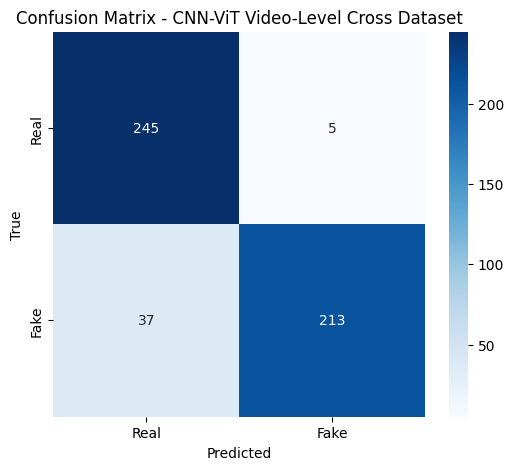

In [ ]:
# === VIDEO-LEVEL INFERENCE ON CROSS-DATASET (CNN-ViT) ===
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from pathlib import Path
import glob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from collections import defaultdict
from google.colab import drive
import numpy as np
import math

# --- Mount Drive ---
# Assuming drive is already mounted. If not, uncomment the next line.
drive.mount('/content/drive', force_remount=True)

# --- Config ---
# <<< --- CHANGE THIS PATH to your saved CNN-ViT model --- >>>
SAVED_MODEL_PATH = "/content/drive/MyDrive/final_balanced_data/cnn__vit_SL30_output/best_model_cnn_vit_L6.pth"

# Data paths (can remain the same if using the same test set)
FINAL_REAL_FRAMES_ZIP = "/content/drive/MyDrive/Test_Dataset/Real/Frames_Real.zip"
FINAL_FAKE_FRAMES_ZIP = "/content/drive/MyDrive/Test_Dataset/Fake/Frames_Fake.zip"
FINAL_REAL_FLOW_ZIP   = "/content/drive/MyDrive/Test_Dataset/Real/Flow_Real.zip"
FINAL_FAKE_FLOW_ZIP   = "/content/drive/MyDrive/Test_Dataset/Fake/Flow_Fake.zip"

# Local unzip dirs
FRAMES_BASE_DIR = "/content/Frames"
FLOW_BASE_DIR   = "/content/Flow"

# Model Hyperparameters (must match the trained CNN-ViT model)
VIT_EMBED_DIM = 768
VIT_NUM_HEADS = 12
VIT_NUM_LAYERS = 6
VIT_MLP_DIM = 3072
FLOW_DIM = 2
NUM_CLASSES = 2
DROPOUT_RATE = 0.5 # Match the rate used in your training script's classifier
SEQ_LENGTH = 30
INFERENCE_STEP_SIZE = SEQ_LENGTH // 2  # 50% overlap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper: unzip (assuming it's already defined and run from the LSTM script) ---
def unzip_to_dir(zip_path, extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    if not os.listdir(extract_dir):
        print(f"Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(extract_dir)
        print(f"✅ Extracted {zip_path} -> {extract_dir}")
    else:
        print(f"ℹ️ Using existing extracted folder: {extract_dir}")

# Unzip frames and flow if not already done
unzip_to_dir(FINAL_REAL_FRAMES_ZIP, os.path.join(FRAMES_BASE_DIR, "Real"))
unzip_to_dir(FINAL_FAKE_FRAMES_ZIP, os.path.join(FRAMES_BASE_DIR, "Fake"))
unzip_to_dir(FINAL_REAL_FLOW_ZIP,   os.path.join(FLOW_BASE_DIR, "Real"))
unzip_to_dir(FINAL_FAKE_FLOW_ZIP,   os.path.join(FLOW_BASE_DIR, "Fake"))

# --- Image Transform (Identical to maintain consistency) ---
IMG_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Model Definition (CNN-ViT) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DeepfakeDetectionModel_CNNViT(nn.Module):
    def __init__(self, cnn_output_dim_from_resnet=512, vit_embed_dim=VIT_EMBED_DIM,
                 vit_num_heads=VIT_NUM_HEADS, vit_num_layers=VIT_NUM_LAYERS,
                 vit_mlp_dim=VIT_MLP_DIM, sequence_length=SEQ_LENGTH,
                 flow_dim=FLOW_DIM, num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE,
                 freeze_cnn_layers=False): # freeze_cnn_layers is irrelevant for inference
        super(DeepfakeDetectionModel_CNNViT, self).__init__()
        _resnet = models.resnet18(weights=None) # No need for pretrained weights when loading a state_dict
        self.cnn_backbone = nn.Sequential(*list(_resnet.children())[:-1])
        self.cnn_feature_proj = nn.Linear(cnn_output_dim_from_resnet, vit_embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, vit_embed_dim))
        self.pos_encoder = PositionalEncoding(vit_embed_dim, max_len=sequence_length + 1)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vit_embed_dim, nhead=vit_num_heads, dim_feedforward=vit_mlp_dim,
            dropout=dropout_rate, batch_first=True, activation='gelu'
        )
        self.vit_encoder = nn.TransformerEncoder(encoder_layer, num_layers=vit_num_layers)
        self.flow_dim = flow_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(vit_embed_dim + self.flow_dim),
            nn.Linear(vit_embed_dim + self.flow_dim, vit_embed_dim // 2), nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(vit_embed_dim // 2, num_classes)
        )

    def forward(self, frames, flow_features_sequence):
        batch_size, seq_len, _, _, _ = frames.size()
        cnn_features_list = [self.cnn_backbone(frames[:, t, :, :, :]).view(batch_size, -1) for t in range(seq_len)]
        cnn_sequence_features = torch.stack(cnn_features_list, dim=1)
        vit_input_features = self.cnn_feature_proj(cnn_sequence_features)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, vit_input_features), dim=1)
        x = self.pos_encoder(x)
        vit_encoded_output = self.vit_encoder(x)
        vit_sequence_output = vit_encoded_output[:, 0]
        if flow_features_sequence is not None and flow_features_sequence.ndim == 3:
            aggregated_flow_features = torch.mean(flow_features_sequence, dim=1)
        else:
            aggregated_flow_features = torch.zeros(batch_size, self.flow_dim, device=frames.device)
        combined_features = torch.cat((vit_sequence_output, aggregated_flow_features), dim=1)
        return self.classifier(combined_features)

# --- Load Model ---
model = DeepfakeDetectionModel_CNNViT().to(DEVICE)
model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ CNN-ViT Model loaded successfully.")

# --- Helper: Load sequence of frames (Identical) ---
def load_frame_sequence(frame_paths):
    imgs = [IMG_TRANSFORM(Image.open(p).convert("RGB")) for p in frame_paths]
    return torch.stack(imgs)

# --- Collect sequences with overlapping (Identical) ---
def collect_sequences(label):
    frame_dirs = sorted(glob.glob(os.path.join(FRAMES_BASE_DIR, label, "*")))
    sequences = defaultdict(list)
    for vid_dir in frame_dirs:
        vid_name = Path(vid_dir).stem
        frame_paths = sorted(glob.glob(os.path.join(vid_dir, "*.jpg")))
        for seq_idx in range(0, len(frame_paths) - SEQ_LENGTH + 1, INFERENCE_STEP_SIZE):
            seq_frames = frame_paths[seq_idx: seq_idx + SEQ_LENGTH]
            if len(seq_frames) == SEQ_LENGTH:
                # Assuming flow naming convention is consistent
                flow_name = f"{label.lower()}_{vid_name}_seq{seq_idx//INFERENCE_STEP_SIZE}.pt"
                flow_path = os.path.join(FLOW_BASE_DIR, label, flow_name)
                if os.path.exists(flow_path):
                    sequences[vid_name].append((seq_frames, flow_path, 0 if label=="Real" else 1))
    return sequences

print("📂 Collecting sequences for CNN-ViT inference...")
real_sequences = collect_sequences("Real")
fake_sequences = collect_sequences("Fake")

# --- Hybrid decision rule (Identical) ---
def hybrid_video_decision(seq_outputs, avg_threshold=0.45, seq_threshold=0.55):
    probs_list = [torch.softmax(out, dim=1).squeeze().cpu().numpy() for out in seq_outputs]
    fake_probs = [p[1] for p in probs_list]
    avg_fake = np.mean(fake_probs)
    any_fake = any(p >= seq_threshold for p in fake_probs)
    if avg_fake >= avg_threshold or any_fake:
        return 1  # Fake
    return 0  # Real

# --- Run inference (Identical logic) ---
y_true, y_pred = [], []
with torch.no_grad():
    for vid_dict, label_name in [(real_sequences, "Real"), (fake_sequences, "Fake")]:
        for vid_name, seq_list in vid_dict.items():
            true_label = 0 if label_name == "Real" else 1
            seq_outputs = []
            for frame_paths, flow_path, _ in seq_list:
                frames_tensor = load_frame_sequence(frame_paths).unsqueeze(0).to(DEVICE)
                flow_tensor = torch.load(flow_path).unsqueeze(0).to(DEVICE)
                outputs = model(frames_tensor, flow_tensor)
                seq_outputs.append(outputs)
            if seq_outputs:
                # Using the same decision thresholds for a fair comparison
                final_pred = hybrid_video_decision(seq_outputs, avg_threshold=0.4, seq_threshold=0.6)
                y_true.append(true_label)
                y_pred.append(final_pred)

# --- Metrics (Identical) ---
print("\n--- FINAL EVALUATION RESULTS (CNN-ViT) ---")
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.4f} ({acc:.2%})")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.title("Confusion Matrix - CNN-ViT Video-Level Cross Dataset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# === SINGLE VIDEO UPLOAD + ON-THE-FLY INFERENCE (CNN-ViT) ===
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np
from google.colab import drive, files
import math

# --- Config ---
# <<< --- CHANGE THIS PATH to your saved CNN-ViT model --- >>>
SAVED_MODEL_PATH = "/content/drive/MyDrive/final_balanced_data/cnn__vit_SL30_output/best_model_cnn_vit_L6.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Hyperparameters (must match the trained CNN-ViT model)
SEQ_LENGTH = 30
VIT_EMBED_DIM = 768
VIT_NUM_HEADS = 12
VIT_NUM_LAYERS = 6
VIT_MLP_DIM = 3072
FLOW_DIM = 2
NUM_CLASSES = 2
DROPOUT_RATE = 0.5 # Match the rate used in your training script's classifier
OVERLAP = 15  # frames overlap between sequences

IMG_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Mount Drive ---
drive.mount('/content/drive', force_remount=True)

# --- Model Definition (CNN-ViT) ---
class PositionalEncoding(nn.Module):
    # ... (keep this class definition as is)
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DeepfakeDetectionModel_CNNViT(nn.Module):
    # ... (keep this class definition as is)
    def __init__(self):
        super(DeepfakeDetectionModel_CNNViT, self).__init__()
        _resnet = models.resnet18(weights=None) # No pretrained weights needed for inference
        self.cnn_backbone = nn.Sequential(*list(_resnet.children())[:-1])
        self.cnn_feature_proj = nn.Linear(512, VIT_EMBED_DIM)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, VIT_EMBED_DIM))
        self.pos_encoder = PositionalEncoding(VIT_EMBED_DIM, max_len=SEQ_LENGTH + 1)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=VIT_EMBED_DIM, nhead=VIT_NUM_HEADS, dim_feedforward=VIT_MLP_DIM,
            dropout=DROPOUT_RATE, batch_first=True, activation='gelu'
        )
        self.vit_encoder = nn.TransformerEncoder(encoder_layer, num_layers=VIT_NUM_LAYERS)
        self.classifier = nn.Sequential(
            nn.LayerNorm(VIT_EMBED_DIM + FLOW_DIM),
            nn.Linear(VIT_EMBED_DIM + FLOW_DIM, VIT_EMBED_DIM // 2), nn.GELU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(VIT_EMBED_DIM // 2, NUM_CLASSES)
        )

    def forward(self, frames, flow_features_sequence=None):
        batch_size, seq_len, _, _, _ = frames.size()
        cnn_features_list = [self.cnn_backbone(frames[:, t, :, :, :]).view(batch_size, -1) for t in range(seq_len)]
        cnn_sequence_features = torch.stack(cnn_features_list, dim=1)
        vit_input_features = self.cnn_feature_proj(cnn_sequence_features)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, vit_input_features), dim=1)
        x = self.pos_encoder(x)
        vit_encoded_output = self.vit_encoder(x)
        vit_sequence_output = vit_encoded_output[:, 0]
        if flow_features_sequence is not None:
            aggregated_flow_features = torch.mean(flow_features_sequence, dim=1)
        else:
            aggregated_flow_features = torch.zeros(batch_size, FLOW_DIM, device=frames.device)
        combined_features = torch.cat((vit_sequence_output, aggregated_flow_features), dim=1)
        return self.classifier(combined_features)


# --- Define All Helper Functions ---
def compute_optical_flow(frames):
    # ... (keep this function definition as is)
    flows = [np.array([0.0, 0.0], dtype=np.float32)] # Pad for first frame
    for i in range(len(frames) - 1):
        prev_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        next_gray = cv2.cvtColor(frames[i+1], cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        mag = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
        flows.append(np.array([np.mean(mag), np.var(mag)], dtype=np.float32))
    return torch.tensor(np.array(flows), dtype=torch.float32).unsqueeze(0)


def frames_to_tensor(frames_seq):
    # ... (keep this function definition as is)
    imgs = [IMG_TRANSFORM(Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))) for f in frames_seq]
    return torch.stack(imgs).unsqueeze(0)


def predict_video(video_path, seq_length=SEQ_LENGTH, overlap=OVERLAP, max_sequences=5):
    # ... (keep this function definition as is)
    print(f"Analyzing up to the first {max_sequences} sequences of the video...")
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    if not frames:
        print("Error: Could not read any frames from the video.")
        return -1, []
    if len(frames) < seq_length:
        print(f"Warning: Video is shorter than one sequence ({len(frames)} frames). Padding to {seq_length}.")
        frames.extend([frames[-1]] * (seq_length - len(frames)))
    sequences = []
    step = seq_length - overlap
    for start in range(0, len(frames) - seq_length + 1, step):
        sequences.append(frames[start : start + seq_length])
        if len(sequences) >= max_sequences:
            break
    seq_preds = []
    with torch.no_grad():
        for i, seq in enumerate(sequences):
            print(f"  Processing sequence {i+1}/{len(sequences)}...")
            frames_tensor = frames_to_tensor(seq).to(DEVICE)
            flow_tensor = compute_optical_flow(seq).to(DEVICE)
            out = model(frames_tensor, flow_tensor)
            probs = torch.softmax(out, dim=1).squeeze().cpu().numpy()
            seq_preds.append(int(np.argmax(probs)))
    if not seq_preds:
        print("Warning: No sequences were processed (video might be too short).")
        return -1, []
    final_pred = max(set(seq_preds), key=seq_preds.count)
    return final_pred, seq_preds


# --- MAIN EXECUTION LOGIC ---
# Load the model AFTER defining the class
model = DeepfakeDetectionModel_CNNViT().to(DEVICE)
model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE))
model.eval()
print("✅ CNN-ViT Model loaded successfully.")

# Now, ask for the upload
print("\nPlease upload a video file to analyze.")
uploaded = files.upload()
video_file = list(uploaded.keys())[0]

# Finally, run the prediction
label, seqs = predict_video(video_file)
if label != -1:
    print("\n--- PREDICTION ---")
    prediction_text = "FAKE" if label == 1 else "REAL"
    print(f"Predicted Class: {prediction_text} (raw label: {label})")
    print(f"Sequence-level predictions (0=Real, 1=Fake): {seqs}")

Mounted at /content/drive
✅ CNN-ViT Model loaded successfully.

Please upload a video file to analyze.


Saving id20_0007.mp4 to id20_0007.mp4
Analyzing up to the first 5 sequences of the video...
  Processing sequence 1/5...
  Processing sequence 2/5...
  Processing sequence 3/5...
  Processing sequence 4/5...
  Processing sequence 5/5...

--- PREDICTION ---
Predicted Class: REAL (raw label: 0)
Sequence-level predictions (0=Real, 1=Fake): [0, 0, 0, 0, 0]
